In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from pandas import set_option
set_option("display.max_rows", 16)


In [2]:
# read data from the Excel file
data=pd.read_excel('./Direktvermarktung-Uebersicht_Jan_2016.xlsx',sheetname='DV-MPM')
data

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Mrz,Apr,Mai,Jun,Jul,Aug,Sep,Okt,Nov,Dez
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# print the and its type
print data
type(data)

                   ÜNB  Netzbetreiber Betriebsnummer  \
0              Amprion                    10001607.0   
1              Amprion                    10003764.0   
2              Amprion                    10001607.0   
3              Amprion                    10003764.0   
4              Amprion                    10003764.0   
5              Amprion                    10003764.0   
6              Amprion                    10000055.0   
7              Amprion                    10000055.0   
...                ...                           ...   
32456  TransnetBW GmbH                    10003223.0   
32457  TransnetBW GmbH                    10000843.0   
32458  TransnetBW GmbH                    10000843.0   
32459  TransnetBW GmbH                    10000843.0   
32460  TransnetBW GmbH                    10000843.0   
32461  TransnetBW GmbH                    10001495.0   
32462  TransnetBW GmbH                    10002974.0   
32463  TransnetBW GmbH                    100008

pandas.core.frame.DataFrame

In [4]:
# encode Energietraeger to integer class labels:
from sklearn import preprocessing
encodeEnergietr = preprocessing.LabelEncoder()
data["Energietraeger_enc"]=encodeEnergietr.fit_transform(data["Energietraeger"])

In [5]:
data

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Apr,Mai,Jun,Jul,Aug,Sep,Okt,Nov,Dez,Energietraeger_enc
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
from sklearn.cross_validation import train_test_split
variables = ["Installierte Leistung in kW"]

X=data[variables].values
y=data["Energietraeger_enc"]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=1999)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)
#pred_score = classifier.decision_function(test_X)
print("Fraction Correct")
print(np.sum(pred_y == test_y) / float(len(test_y)))

Fraction Correct
0.672498767866


test score   0.672498767866
train score  0.687161163135


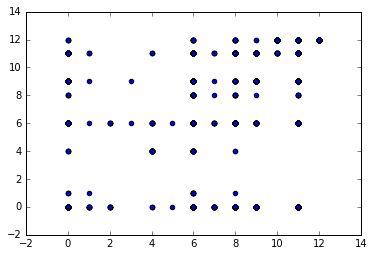

In [8]:
print "test score  ", classifier.score(test_X, test_y)

print "train score ", classifier.score(train_X, train_y)

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)


In [9]:
pred_y

array([ 0, 11,  9, ..., 11,  9,  0], dtype=int64)

In [10]:
# read PLZ data:
plz=pd.read_csv("PLZ.tab", sep="\t")
plz["PLZ"]=plz["plz"]
plz

,#loc_id,plz,lon,lat,Ort,PLZ
0,5078,1067,13.721068,51.060034,Dresden,1067
1,5079,1069,13.738907,51.039559,Dresden,1069
2,5080,1097,13.743967,51.066745,Dresden,1097
3,5081,1099,13.828980,51.092619,Dresden,1099
4,153646,1108,13.828980,51.092619,Dresden,1108
5,5082,1109,13.761965,51.120101,Dresden,1109
6,5083,1127,13.733347,51.079630,Dresden,1127
7,5084,1129,13.727410,51.096794,Dresden,1129
...,...,...,...,...,...,...
8281,12805,99974,10.458195,51.243633,Mühlhausen,99974


In [11]:
# join data with PLZ:
data2 = pd.merge(data, plz, how='left', on="PLZ").fillna(0.)
data2

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Sep,Okt,Nov,Dez,Energietraeger_enc,#loc_id,plz,lon,lat,Ort
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8304.0,49847.0,6.751713,52.515639,Itterbeck
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8288.0,49767.0,7.095613,52.668487,Twist
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8296.0,49824.0,6.844740,52.615410,Emlichheim
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8282.0,49733.0,7.199469,52.797957,Haren (Ems)
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8282.0,49733.0,7.199469,52.797957,Haren (Ems)
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8253.0,49509.0,7.704652,52.364821,Recke
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,0.0,0.0,0.0,0.0,8,11413.0,87541.0,10.399859,47.472895,Hindelang
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,0.0,0.0,0.0,0.0,8,11413.0,87541.0,10.399859,47.472895,Hindelang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,9638.0,69123.0,8.628442,49.417402,Heidelberg


In [148]:
# use lat/lon:
from sklearn.cross_validation import train_test_split
variables = ["Installierte Leistung in kW", "lat", "lon"]


#variables = ["Installierte Leistung in kW", "Geothermie",
#             "Solar", "Wasser", "Wind"]
#lables = [ "Geothermie", "Solar", "Wasser", "Wind"]


X=data2[variables].values
y=data2["Energietraeger_enc"]
names = data2["Energietraeger"]
ids = np.unique(y), 
lab = np.unique(names)
print ids, lab

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=1999)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),) [u'Biomasse' u'Deponiegas' u'Gas' u'Geothermie' u'Grubengas' u'Kl\xe4rgas'
 u'Solar' u'Wasser' u'Wasserkraft' u'Wind' u'Wind offshore' u'Windenergie'
 u'Windenergie Offshore']


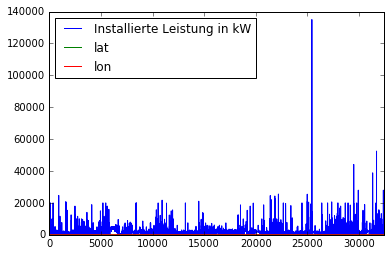

In [149]:
data2[variables].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000267D5EB8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002CEC3470>]], dtype=object)

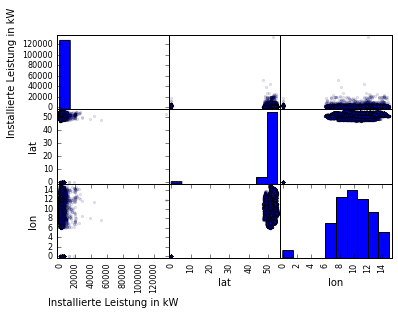

In [150]:
pd.scatter_matrix(data2[variables], alpha=0.1)

In [151]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)
print("Fraction Correct")
print(np.sum(pred_y == test_y) / float(len(test_y)))

Fraction Correct
0.88442582553


test score   0.88442582553
train score  0.917015771316


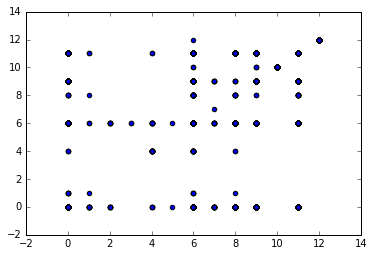

In [152]:
print "test score  ", classifier.score(test_X, test_y)

print "train score ", classifier.score(train_X, train_y)

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)

[[3104    8    6    0    4    1  505   12   64   48    0   72    0]
 [   5    1    0    0    0    0    4    0    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   3    0    0    0   15    0   14    0    2    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 265    2    6    2    9    1 1220    8   43   22    0   62    0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0]
 [   5    1    0    0    0    0   19    0    9    2    0   10    0]
 [ 107    0    0    0    0    0  119    5    4 3807    0   41    0]
 [   0    0    0    0    0    0    2    0    0    3   54    0    0]
 [ 201    2    0    0    2    0  103    0   34   46    0 5786    0]
 [   0    0    0    0    0    0    1    0    0    0    0    0  359]]


([<matplotlib.axis.YTick at 0x30d0e6a0>,
 <a list of 13 Text yticklabel objects>)

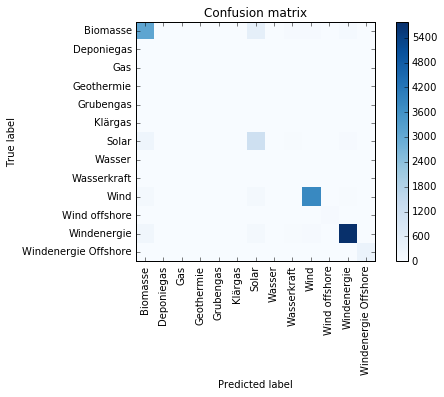

In [154]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(13)
    #plt.xticks(tick_marks, data["Index"], rotation=45)
    #plt.yticks(tick_marks, data["Index"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# test how well the prediction worked.
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(pred_y, test_y)
print (cm)
plot_confusion_matrix(cm)
tick_marks = np.arange(len(lab))
plt.xticks(tick_marks, lab, rotation=90)
plt.yticks(tick_marks, lab)

Normalized confusion matrix
[[  8.11715481e-01   2.09205021e-03   1.56903766e-03   0.00000000e+00
    1.04602510e-03   2.61506276e-04   1.32060669e-01   3.13807531e-03
    1.67364017e-02   1.25523013e-02   0.00000000e+00   1.88284519e-02
    0.00000000e+00]
 [  4.54545455e-01   9.09090909e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   3.63636364e-01   0.00000000e+00
    9.09090909e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [             nan              nan              nan              nan
               nan              nan              nan              nan
               nan              nan              nan              nan
               nan]
 [             nan              nan              nan              nan
               nan              nan              nan              nan
               nan              nan              nan              nan
               nan]
 [  8.82352941e-02   0.00000000e+00   0.00000000e+00

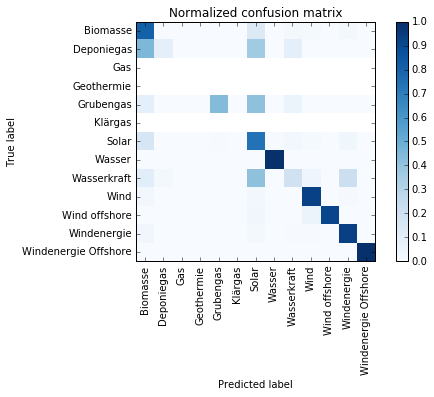

In [155]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
tick_marks = np.arange(len(lab))
plt.xticks(tick_marks, lab, rotation=90)
plt.yticks(tick_marks, lab)
plt.show()

[u'Biomasse' u'Wasserkraft' u'Solar' u'Windenergie' u'Geothermie'
 u'Grubengas' u'Deponiegas' u'Kl\xe4rgas' u'Windenergie Offshore' u'Wind'
 u'Gas' u'Wasser' u'Wind offshore']
[ 0  8  6 11  3  4  1  5 12  9  2  7 10]


(23198, 30)

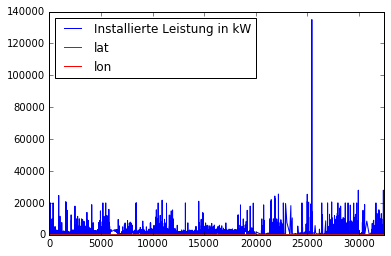

In [142]:
print pd.unique(data2.Energietraeger)
print pd.unique(data2.Energietraeger_enc)
#data3=data2.loc[data2['Energietraeger'].isin(['Solar','Wind','Wasser'])]
#Biomasse             =  7389, id =  0
#Wasserkraft          =   316, id =  8  
#Solar                =  3887, id =  6
#Windenergie          = 12022, id = 11
#Geothermie           =     3, id =  3
#Gruebengas           =    64, id =  4
#Deponiertgas         =    37, id =  1
#Klaeregas            =     3, id =  5
#Windenergie Offshore =   688, id = 12
#Wind                 =  7973, id =  9
#Gas                  =    23, id =  2
#Wasser               =    58, id =  7
#Wind offshore        =   101, id = 10
#
data3=data2.loc[data2['Energietraeger_enc'].isin([0,6,11])]
data3[variables].plot()
data3.shape

In [143]:
data3.shape

(23198, 30)

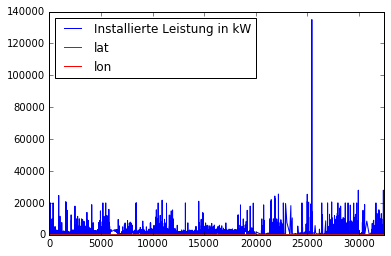

In [144]:
data3[variables].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002FBDE710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002CC97E80>]], dtype=object)

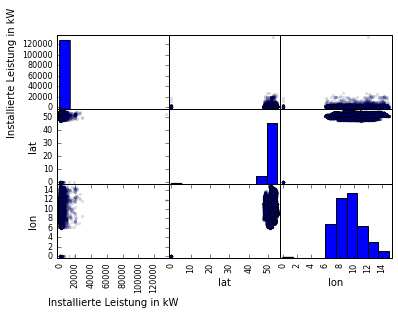

In [145]:
pd.scatter_matrix(data3[variables], alpha=0.1)

(array([ 0,  6, 11], dtype=int64),) [u'Biomasse' u'Solar' u'Windenergie']
Fraction Correct
0.892145874644
test score   0.892145874644
train score  0.919044745237
11599
[[3137  485   70]
 [ 279 1337   69]
 [ 208  140 5874]]
Normalized confusion matrix
[[ 0.84967497  0.13136511  0.01895991]
 [ 0.16557864  0.79347181  0.04094955]
 [ 0.03342977  0.0225008   0.94406943]]


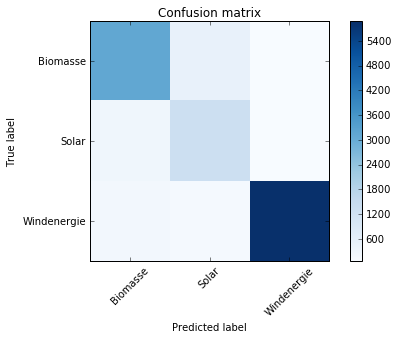

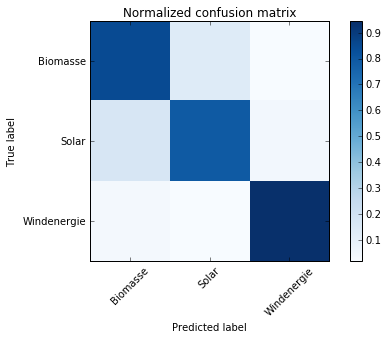

In [146]:
X=data3[variables].values
y=data3["Energietraeger_enc"]
names = data3["Energietraeger"]
ids = np.unique(y), 
lab = np.unique(names)
print ids, lab
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=1999)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)
print("Fraction Correct")
print(np.sum(pred_y == test_y) / float(len(test_y)))
print "test score  ", classifier.score(test_X, test_y)

print "train score ", classifier.score(train_X, train_y)

#fig, ax = plt.subplots()
#ax.scatter(test_y, pred_y)

# test how well the prediction worked.
from sklearn.metrics import confusion_matrix
length = min(len(pred_y), len(train_y))
print length

cm =confusion_matrix(pred_y[:length], test_y[:length])
print (cm)
plot_confusion_matrix(cm)
tick_marks = np.arange(len(lab))
plt.xticks(tick_marks, lab, rotation=90)
plt.yticks(tick_marks, lab)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
tick_marks = np.arange(len(lab))
plt.xticks(tick_marks, lab, rotation=90)
plt.yticks(tick_marks, lab)

plt.show()